<a href="https://colab.research.google.com/github/Laurane67/BINF2025_TP8/blob/main/BINF2025_TP8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BINF TP 8 : Genome wide association study

L'étude d'association pangénomique - Genome Wide Association study (GWAS) - est une méthode permettant de mettre en avant des mutations génétiques associées à une condition. Pour cela, on va recruter un ensemble de sujets possédant la condition que l’on souhaite étudier et un ensemble de sujets contrôle "sains". On va ensuite génotyper (ou séquencer) chaque sujet, c’est-à-dire déterminer les nucléotides présents à un ensembles de positions précises le long du génome. Ces positions sont connues pour posséder plusieurs nucléotides différents (des allèles) dans la population humaine qu'on appelle SNP (Single Nucleotide Polymorphism).

Dans ce TP nous allons chercher les gènes associés aux maladies cornariennes - ensemble de maladies où les artères vascularisant le cœur n’arrivent plus à apporter suffisamment de sang pour alimenter les muscles cardiaques. Nous allons utiliser les données de l’étude [PennCath](https://pmc.ncbi.nlm.nih.gov/articles/PMC3335297/). Cette étude comporte 1401 sujets pour lesquels on a génotypé 860473 positions.

Les données sont disponibles [ici](https://www.dropbox.com/scl/fo/tyt6sx74zevblzl4i5lpr/AAJt-WmbWCKmsPuRyzYPfP0?rlkey=yuklfyfy7b93yn2sow0uzuzub&dl=0). Notez que le fichier de génotypage complet avec 1401 patients fait > 2 go, pour faciliter le TP, nous utiliserons un fichier réduit avec seulement 100 patients.


3.## Exercice 1 : Chargement des données

Les données de l’étude sont divisées en plusieurs fichiers :


* penncath.bim : qui contient les informations sur les positions génotypées (SNPs), une position par ligne avec les colonnes suivantes :
  * Chromosome : pouvant contenir les valeurs 1 – 22, X ou Y.
  * Identifiant de la position dans le génome de référence.
  *	Distance génétique (ignorez cette colonne, elle n’est pas remplie dans le fichier).
  * Position sur le chromosome en paires de bases (on va aussi ignorer cette colonne).
  * Allèle mineure : allèle alternative dans la population (valeurs A,T,G,C ou -9 pour indiquer une absence de données).
  *	Allèle majeure : allèle la plus présente dans la population.

*	penncath.fam : qui contient les informations sur les sujets, une ligne par individu. Dans ce fichier, on s’intéresse uniquement à la première colonne qui contient l’identifiant de la famille.

*	penncath.csv : qui contient des informations cliniques sur les patients, en particulier s’il est atteint de la maladie coronarienne. Ce fichier contient une ligne par patient avec les colonnes suivantes :
   * Id du patient correspondant à la première colonne du fichier fam.
   * Maladie coronarienne : 1=OUI, 0=NON.
   * Les autres colonnes ne nous intéressent pas.

* genotype_small.csv : contient les donnes de génotypage, une colonne par patient, une ligne par position génotypée. Les valeurs sont : 0 : homozygote allèle majeur, 1 : hétérozygote, 2 : homozygote allèle mineure, 3 : génotype manquant.

Chargez les différents fichiers en faisant attention à bien maintenir l’ordre des lignes entre patients et génotypes et associez à chaque patient son statut malade ou sain.

In [6]:
!unzip data.zip

Archive:  data.zip
mapname:  conversion of  failed
 extracting: penncath.bim            
 extracting: penncath.csv            
 extracting: penncath.fam            
 extracting: genotypes_small.csv     


In [15]:
patients = {}

with open('/content/penncath.csv', 'r') as file:
  l = [line for line in file]
  for line in l[1:]:
    line = line.strip().split(',')
    patients[line[0][1:-1]] = line[1]

print(patients['10002'])
print(patients['10004'])
print(patients['10013'])

1
1
0


## Exercice 2 : contrôle qualité

Comme on manipule des données brutes, certaines vont être problématiques et on va vouloir les enlever pour éviter de biaiser les résultats. Dans cette exercice, nous allons détecter et filtrer les données problématiques.


1. Vérifions la distribution des données par chromosome. Affichez le nombre de SNP pour chaque chromosome sous la forme d'un barplot (l'axe x représente chaque chromosome et l'axe y le nombre de SNPs correspondant).

[71038, 73717, 60565, 55675, 56178, 54176, 46391, 48299, 41110, 47930, 44213, 42124, 34262, 28054, 25900, 27591, 19939, 26231, 11482, 22753, 12463, 11382, 0]


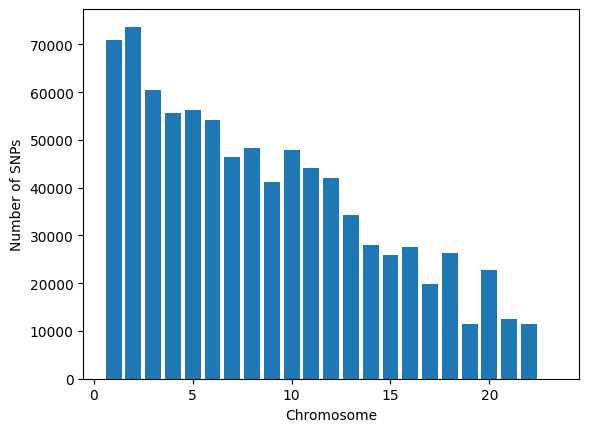

In [35]:
import matplotlib.pyplot as plt

histo = [0 for i in range(23)]
x = [i+1 for i in range(23)]

with open('/content/penncath.bim', 'r') as file:
  line_chr = [line for line in file]

for line in line_chr:
  line = line.strip().split(' ')
  histo[int(line[0])-1] += 1

print(histo)

plt.bar(x, histo)
plt.xlabel('Chromosome')
plt.ylabel('Number of SNPs')
plt.show()

2. Qu’observez-vous ?

On n'a pas de X ou Y, et le nombre de SNPs diminue avec le numéro du chromosome.

2. Vérifions maintenant les valeurs des allèles. Affichez un barplot comptant la quantité de chaque nucléotide apparaissant dans les allèles mineures (-9 signifie une absence de données, affichez le dans le graphique, c’est important).


[220531, 221909, 190312, 202567, 26154]


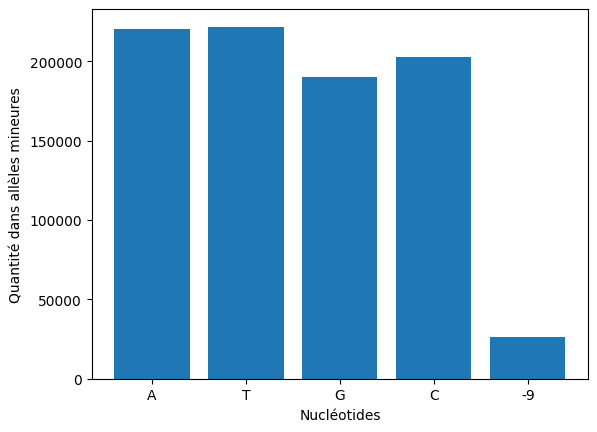

In [38]:
nt = ['A', 'T', 'G', 'C', '-9']
histo = [0 for i in range(5)]

for line in line_chr:
  line = line.strip().split(' ')
  if line[4] in nt:
    histo[nt.index(line[4])] += 1

print(histo)
plt.bar(nt, histo)
plt.xlabel('Nucléotides')
plt.ylabel('Quantité dans allèles mineures')
plt.show()

3. Faites de même avec les valeurs de l’allèle majeure.


[195120, 185336, 232858, 248158, 1]


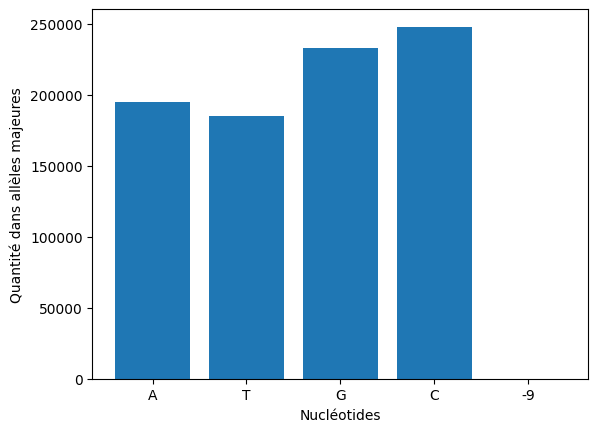

In [40]:
nt = ['A', 'T', 'G', 'C', '-9']
histo = [0 for i in range(5)]

for line in line_chr:
  line = line.strip().split(' ')
  if line[5] in nt:
    histo[nt.index(line[5])] += 1

print(histo)
plt.bar(nt, histo)
plt.xlabel('Nucléotides')
plt.ylabel('Quantité dans allèles majeures')
plt.show()

4. Qu’observez-vous en comparant ces deux graphiques ?

La quantité est à peu près équilibrée. Il y a des inconnues seulement dans les allèles mineures.

5. Intéressons-nous maintenant aux données de génotypage. Dans ces données, une valeur NAN indique qu’il y a eu une erreur au niveau de l'acquisition des données. Affichez l’histogramme du nombre d’erreurs de génotypage par patient (nombre de NAN ou valeurs 4).

In [ ]:
print("Votre code ici !!")

6. Affichez l’histogramme du nombre d’erreurs par position de SNP (nombre de NAN ou valeurs 4).

In [ ]:
print("Votre code ici !!")

7. Retirez tous les SNP qui possèdent des valeurs à NaN ainsi que ceux possédant une seule valeur chez tous les patients. Faites attention de garder la liste des caractéristiques des SNP bien synchronisé car nous l’utiliserons pour la dernière question.

In [ ]:
print("Votre code ici !!")

## Exercice 3 : Association

Pour chaque SNP on va calculer sa probabilité d’être sur ou sous-représenté dans la population malade comparé à la population contrôle. Il existe plusieurs méthodes statistiques plus ou moins sophistiquées pour faire celà, nous allons voir la méthode la plus simple utilisant des tableaux de comptes d’allèles.

1. Pour chaque génotype k, construisez le tableau 2x2 suivant O :
$$\begin{array}{|l|ll|}
\hline
& Allele\ mineure & Allele\ majeure\\\hline
sain & a & b\\
malade & c & d\\
\hline
\end{array}$$
où $a,b$ sont les nombres de patients sain possédant l'allèle mineure ou majeure (respectivement) et $c,d$ les nombres de patients malades possédant l'alèlle mineure ou majeure (respectivement), pour le génotype $k$.

In [ ]:
print("Votre code ici !!")

2. 	Pour chaque génotype $k$, calculez une p-value en effectuant un test du $\chi^2$ sur la table $O$ :
$$
z_{ij} = \frac{(o_{ij}-e_{ij})^2}{e_{ij}},
$$
où $o_{ij}$ est la valeure de la case $i,j$ de la table $O$ (la valeure observée) et $e$ la valeur attendue selon l'hypothèse nulle calculée par:
$$e_{ij} = \frac{\left(\sum\limits_{k=1}^{2}o_{k,j}\right)\left(\sum\limits_{k=1}^{2}o_{i,k}\right)}{\sum\limits_{k=1}^{2}\sum\limits_{l=1}^{2} o_{kl}}.$$

 Finalement $z = z_{11} + z_{12} + z_{21} + z_{22}$ doit suivre une loi du $\chi^2$ à 1 degré de liberté. La p-value que le génotype mutant du SNP $k$ ait un effet sur la maladie est donnée par la probabilité associée à $z$.

 Vous pouvez utilisez la fonction chi2_contingency de scipy.stats.

In [ ]:
print("Votre code ici !!")

3. Affichez les résultat sous forme de graphique de Manhattan. Affichez toutes les paires (i, -log10(pval[i])) avec un marqueur « . ».

In [ ]:
print("Votre code ici !!")

4. Finalement, affichez les identifiants de tous les SNPs significativement plus présents chez les patients malades que sain. C'est à dire, les SNP avec
$$-log10(pval) > 5$$

In [ ]:
print("Votre code ici !!")